Detected 2 gpus!
Case pglib_opf_case118_ieee: buses: 118, lines: 186, trafos: 11, trafosum: 10.59, gens: 54
Case pglib_opf_case793_goc: buses: 793, lines: 913, trafos: 145, trafosum: 145.5452, gens: 97
Case pglib_opf_case1354_pegase: buses: 1354, lines: 1991, trafos: 240, trafosum: 230.55665400000004, gens: 260
Case pglib_opf_case2312_goc: buses: 2312, lines: 3013, trafos: 857, trafosum: 857.70082, gens: 226
Case pglib_opf_case4601_goc: buses: 4601, lines: 7199, trafos: 2054, trafosum: 2054.0, gens: 408
Case pglib_opf_case10000_goc: buses: 10000, lines: 13193, trafos: 2374, trafosum: 2410.97125, gens: 2016


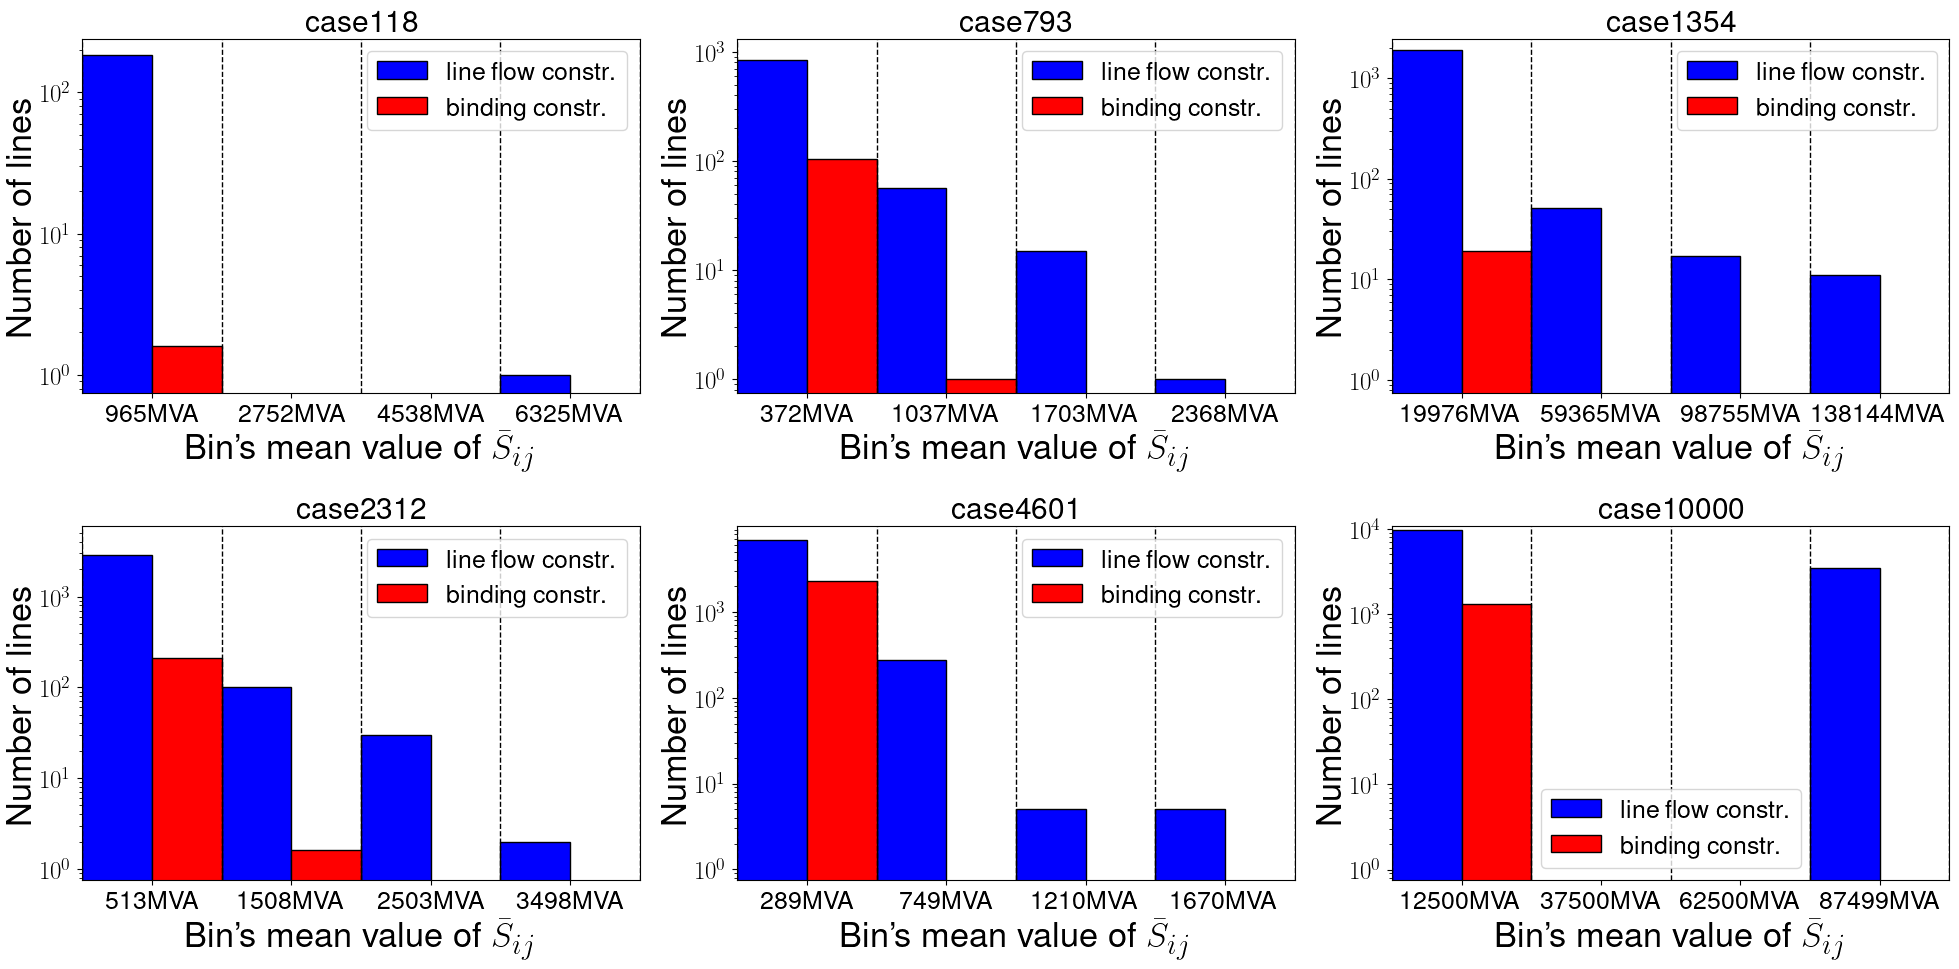

In [18]:
import os, pickle
import numpy as np
import torch.nn.functional as F
import torch
import warnings
from tqdm import trange
from pypower.ext2int import ext2int
from pypower.api import loadcase
from problemDefJITM import opfSocp
from problemDefJITMargin import opfSocpMargin
from utils import make_data_parallel
from tqdm import tqdm, trange
import torch
import torch.nn as nn
import gc
from time import time
from oct2py import Oct2Py
import networkx as nx
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 18  # Increase font size
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb,times}'
plt.rcParams['axes.labelsize'] = 18  # Increase axis label size
plt.rcParams['xtick.labelsize'] = 18  # Increase x-tick label size
plt.rcParams['ytick.labelsize'] = 18  # Increase y-tick label size
plt.rcParams['legend.fontsize'] = 18  # Increase legend font size
plt.rcParams['figure.titlesize'] = 18  # Increase figure title size

warnings.filterwarnings("ignore", category=UserWarning)

octave = Oct2Py()
dir_name = 'data/'
MAX_BUS = 10000
DUAL_THRES = 1e-4
DEVICE_MODULO = 2

def filtered_nx_graph(from_node,to_node,wt_edge,G):
    for f,t,w in zip(from_node,to_node,wt_edge):
        G.add_edge(f,t,weight=w)
    return G

def zero_one_scaling(x):
    xprime = 1 + ((x - x.min()) / (x.max() - x.min()))
    return xprime

    
# print number of devices
print(f"Detected {torch.cuda.device_count()} gpus!")

# get all cases in current directory
current_directory = os.getcwd()+'/'
# current_directory = '/home/sbose/pglib-opf/' # for running on BEBOP
all_files_and_directories = os.listdir(current_directory)
# three specific cases
todo_cases =  ['pglib_opf_case118_ieee','pglib_opf_case793_goc','pglib_opf_case1354_pegase','pglib_opf_case2312_goc','pglib_opf_case4601_goc','pglib_opf_case10000_goc']
case_files = [current_directory+i for i in [c+'.m' for c in todo_cases]]

cases, casenames = [], []
cases_full, casenames_full = [], []
for cf in case_files:
    octave.source(current_directory+os.path.basename(cf))
    cname = os.path.basename(cf).split('.')[0]
    num_buses = None
    # determine number of buses in the case from its name
    for ci in cname.split('_'):
        if 'case' in ci:
            num_buses = int(''.join([chr for chr in ci.replace('case','',1) if chr.isdigit()]))
    # fitler out cases with more buses than MAX_BUS
    if num_buses <= MAX_BUS:
        # convert to internal indexing
        case_correct_idx = ext2int(loadcase(octave.feval(cname)))
        # append
        cases.append(case_correct_idx)
        casenames.append(cname)

nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows, ncols, figsize = (20,10))
for cid,(cn,cs) in enumerate(zip(casenames,cases)):
    
    ntrafo = (1-np.isclose(cs.branch[:,8],0.).astype(int)).sum()
    nbus = cs.bus.shape[0]
    print(f"Case {cn}: buses: {cs.bus.shape[0]}, lines: {cs.branch.shape[0]}, trafos: {ntrafo}, trafosum: {cs.branch[:,8].sum()}, gens: {cs.gen.shape[0]}")
    
    # Gc = nx.DiGraph()
    flowlims_orig = cs.branch[:,5]
    flowlims = zero_one_scaling(flowlims_orig)
    # Gc = filtered_nx_graph(cs.branch[:,0],cs.branch[:,1],flowlims,Gc)
    # pos = nx.nx_agraph.graphviz_layout(Gc, prog="neato")
    # weights = [edge[2]['weight'] for edge in Gc.edges(data=True)]
    # percentile_50 = np.percentile(weights, 50)
    # # edge_styles = ['solid' if Gc[u][v]['weight'] > percentile_50 else 'dashed' for u, v in Gc.edges()]
    # plt.figure(figsize=(6, 6))
    # nx.draw(Gc,pos,with_labels=False,edge_color='black',node_size=0,alpha=0.75 if cs.bus.shape[0]<2000 else 0.7,arrows=False)
    # plt.gca().margins(x=0,y=0)
    # # for (u, v), style in zip(Gc.edges(), edge_styles):
    # #     nx.draw_networkx_edges(Gc, pos, edgelist=[(u, v)], style=style, edge_color='black', alpha = 0.75 if cs.bus.shape[0]<2000 else 0.5, arrows=False)
    # #degrees = [d for _,d in Gc.to_undirected().degree()]
    # #plt.hist(degrees)
    # plt.axis('off')
    # plt.savefig(f"{cn}_layout.pdf",format="pdf",bbox_inches="tight")
    # plt.show()
    rowid, colid = cid // 3, cid % 3
    ax = axs[rowid,colid]
    #### data
    n_bus, n_branch = cs.bus.shape[0], cs.branch.shape[0]
    bind_data = np.load(os.getcwd()+f'/saved/{cn}_test_gt.npz')['data']
    flow_f_data = bind_data[:,0:n_branch].mean(axis=0)
    flow_t_data = bind_data[:,n_branch:2*n_branch].mean(axis=0)
    flow_data = 0.5*(flow_f_data+flow_t_data)
    data_min, data_max = flowlims_orig.min(), flowlims_orig.max()
    bins = np.linspace(data_min, data_max, 5)
    idx_bins = [np.where((flowlims_orig>=bins[i])&((flowlims_orig<bins[i+1]) if i<(bins.size-2) else (flowlims_orig<=bins[i+1])))[0] for i in range(bins.size-1)]
    hist_heights = np.array([flow_data[idx].sum() if idx.size>0 else 0 for idx in idx_bins])
    # counts
    counts1, _ = np.histogram(flowlims_orig,bins=bins)
    counts2 = hist_heights
    #### data over
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bar_width = (bins[1]-bins[0]) / 2
    bar1_positions = bin_centers - bar_width / 2
    bar2_positions = bin_centers + bar_width / 2
    # do the actual plotting
    bars1 = ax.bar(bar1_positions,counts1,width=bar_width,edgecolor='black',label=r'line flow constr.')
    bars2 = ax.bar(bar2_positions,counts2,width=bar_width,edgecolor='black',label=r'binding constr.')
    patches1, patches2 = bars1.patches, bars2.patches
    # n, bins, patches = plt.hist(flowlims_orig, bins=bins, edgecolor='black', rwidth=0.5)
    for patch1,patch2 in zip(patches1,patches2):
        patch1.set_facecolor('blue')
        patch2.set_facecolor('red')
        # patch1.set_alpha(0.5)
    for b in bins:
        ax.axvline(b, color='k', linestyle='dashed', linewidth=1)
    # Set x-ticks at the center of each bin
    ax.set_xticks(bin_centers, labels=[f'{center:.0f}MVA' for center in bin_centers])
    ax.set_xlim(bins[0], bins[-1])
    ax.set_yscale('log')
    ax.set_ylim(bottom=0.75)
    ax.set_xlabel(r"\Huge Bin's mean value of $\bar{S}_{ij}$")
    ax.set_ylabel(r'\Huge Number of lines')
    ax.set_title(f"case{nbus}")
    yt = ax.get_yticks()
    yl = ax.get_ylim()
    ax.legend(loc='upper right')
    # plt.savefig(f"{cn}_hist2.pdf",format="pdf",bbox_inches="tight")
    # # plot binding constraints
    # plt.figure(figsize=(6,6))
    # idx_bins = [np.where((flowlims_orig>=bins[i])&((flowlims_orig<bins[i+1]) if i<(bins.size-2) else (flowlims_orig<=bins[i+1])))[0] for i in range(bins.size-1)]
    # n_bus, n_branch = cs.bus.shape[0], cs.branch.shape[0]
    # bind_data = np.load(os.getcwd()+f'/saved/{cn}_test_gt.npz')['data']
    # flow_f_data = bind_data[:,0:n_branch].mean(axis=0)
    # flow_t_data = bind_data[:,n_branch:2*n_branch].mean(axis=0)
    # flow_data = 0.5*(flow_f_data+flow_t_data)
    # hist_heights = np.array([flow_data[idx].sum() if idx.size>0 else 0 for idx in idx_bins])
    # n, bins, patches = plt.hist(flowlims_orig, bins=bins, edgecolor='black', rwidth=0.5)
    # for pidx,patch in enumerate(patches):
    #     patch.set_facecolor('gray')
    #     patch.set_alpha(0.5)
    #     patch.set_height(hist_heights[pidx])
    # for b in bins:
    #     plt.axvline(b, color='k', linestyle='dashed', linewidth=1)
    # plt.xticks(bin_centers, labels=[f'{center:.0f}MW' for center in bin_centers])
    # plt.xlim(bins[0], bins[-1])
    # plt.yscale('log')
    # plt.gca().set_yticks(yt)
    # plt.gca().set_ylim(yl)
    # # plt.ylim(ylims)
    # plt.xlabel(r'\Huge\texttt{Values of }$\bar{S}_{ij}$')
    # plt.ylabel(r'\Huge\texttt{Avg. binding lines}')
    # plt.savefig(f"{cn}_bind.pdf",format="pdf",bbox_inches="tight")
    # plt.show()
    
# fig, axs = plt.subplots(3, 2)

# for i, ax in enumerate(axes):
#     row = i // 2
#     col = i % 2
#     axs[row, col] = ax
# plt.tight_layout()
plt.tight_layout(pad=1.0)
plt.savefig(f"flows.pdf",format="pdf",bbox_inches="tight")
plt.show()